In [1]:
import sys
sys.path.append("..\\") # parent directory
from AQUA_general import AQUA
from batchAQUA_general import batchAQUA
from stimulus import *
from plotting_functions import *
from phase_response import *


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from functions import *

In [2]:
RS = {'name': 'RS', 'C': 100, 'k': 0.7, 'v_r': -60, 'v_t': -40, 'v_peak': 35,
    'a': 0.03, 'b': 40, 'c': -50, 'd': 100, 'e': 0., 'f': 0.0, 'tau': 0.0}
#'e': 0.2, 'f': 150.0, 'tau': 2.0

In [3]:
T = 2
dt = 0.01
N_iter = int(1000*T/dt)

# number of neurons
N_neurons = 600

# frequencies to sample
f_range = np.linspace(1, 200, N_neurons)

threshold, x_ini = find_threshold(RS, np.linspace(50, 400, 50), T, dt)
print(threshold)
x_start = np.full((N_neurons, 3), x_ini)
t_start = np.zeros(N_neurons)

# Setup batch of neurons
params_list = []
for n in range(N_neurons):
    params_list.append(RS)

batch = batchAQUA(params_list)
batch.Initialise(x_start, t_start)


# Setup current pulses
N_pulses = 2
delay = 500 # ms
pulse_duration = 5  # ms
pulse1_end = delay + pulse_duration - dt # ms, from settings above

# minimum pulse height and the time between the end of the pulse and the spike.
pulse_height, time_to_spike = find_pulse_height(RS, np.linspace(100, 1000, 100), threshold, x_ini, pulse_duration)  # pA
# describe ISI range relative to the time since the spike
ISI_range = np.linspace(time_to_spike + 5, 500, N_neurons)


I_inj = np.array([spikes_constant(N_iter, dt, threshold, isi, N_pulses, pulse_height, pulse_duration, delay) for isi in ISI_range])



100%|██████████| 199999/199999 [00:32<00:00, 6094.07it/s]


More precise
[[  nan]
 [  nan]
 [  nan]
 [  nan]
 [  nan]
 [  nan]
 [35.57]
 [32.99]
 [31.68]
 [30.78]
 [30.09]
 [29.53]
 [29.06]
 [28.64]
 [28.28]
 [27.95]
 [27.65]
 [27.37]
 [27.12]
 [26.88]
 [26.66]
 [26.45]
 [26.26]
 [26.07]
 [25.89]
 [25.73]
 [25.56]
 [25.41]
 [25.26]
 [25.12]
 [24.98]
 [24.85]
 [24.73]
 [24.6 ]
 [24.48]
 [24.37]
 [24.25]
 [24.15]
 [24.04]
 [23.94]
 [23.84]
 [23.74]
 [23.64]
 [23.55]
 [23.46]
 [23.37]
 [23.28]
 [23.2 ]
 [23.12]
 [23.03]]
[236.44314869]


100%|██████████| 49999/49999 [00:08<00:00, 5959.71it/s]


In [4]:
# Run simulation
X, T, spikes = batch.update_batch(dt, N_iter, I_inj)



100%|██████████| 199999/199999 [00:59<00:00, 3348.45it/s]


[[29.6647879  14.66060695]
 [12.46105919  0.        ]]


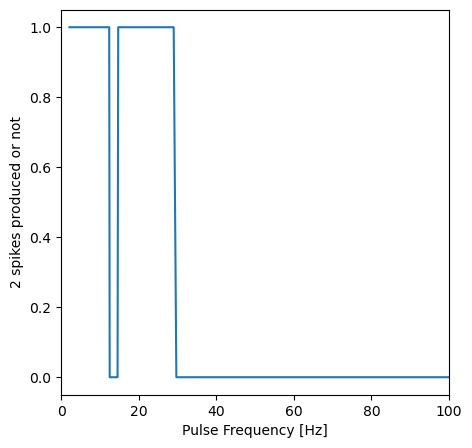

In [5]:
# generate plot of number of spikes versus pulse frequency
# Need to account for the fact there is a spike latency
# end of first pulse is at 500 ms + 5 ms (= delay + pulse_duration)
# resonance frequency is then ISI_pulse - (pulse2_start - spike_time)


pulse2_start = np.zeros(N_neurons)      # store the start of the 2nd pulse for each simulation
spike_boolean = np.zeros(N_neurons)

for n in range(N_neurons):
    if len(spikes[n, np.isnan(spikes[n])]) != 1:
        spike_boolean[n] = 1

    pulse_times = np.argwhere(I_inj[n, :] >= threshold+1)*dt
    pulse2_start[n] = pulse_times[np.where(pulse_times > pulse1_end)][0] 



InterPulse_Intervals = pulse2_start - pulse1_end                    # IPI for all sims

first_spike_time = pulse1_end + time_to_spike

resonant_ISI = pulse2_start - first_spike_time                      # time between first spike and second pulse
resonant_f = 1000/resonant_ISI                                      # corresponding resonance frequency

fig, ax = plt.subplots(1, 1, figsize = (5, 5))
ax.plot(resonant_f, spike_boolean)
ax.set_xlabel("Pulse Frequency [Hz]")
ax.set_ylabel("2 spikes produced or not")
ax.set_xlim((0, 100))
freq_bands = get_resonance_bands(resonant_f, spike_boolean)
print(freq_bands)


#### Now test the multi-pulse protocol


In [12]:
# first enduce a spike and find the height of the second spike which induces a 

pulse_frequency = 20 # Hz
pulse_ISI = 1000/pulse_frequency # ms
pulse2_heights = np.linspace(100, 600, N_neurons)

# get the minimum height of the 2nd pulse.
pulse2_height = find_2nd_pulse_height(RS, pulse2_heights, threshold, x_ini, pulse_duration, pulse_height, time_to_spike, pulse_ISI) + 10
print(pulse2_height)

100%|██████████| 49999/49999 [00:15<00:00, 3210.44it/s]


[[119.35    nan]
 [119.35    nan]
 [119.35    nan]
 ...
 [119.35 177.46]
 [119.35 177.45]
 [119.35 177.43]]


100%|██████████| 49999/49999 [00:15<00:00, 3253.79it/s]

[387.96327212]


In [7]:
## Now use this 2nd pulse height as the standard height for the multipulse train.
# will just apply a fixed number of pulses, see if the pulse after a spike
# also produces a spike. Or rewrite classes to have an exit clause.
multipulse_ISIs = np.linspace(5, 200, N_neurons)
multipulse_freq = 1000/multipulse_ISIs
N_pulses = 20
pulse_duration = 5  # ms
delay = 200         # ms
I_multi = np.array([spikes_constant(N_iter, dt, threshold, isi, N_pulses, pulse2_height, pulse_duration, delay) for isi in multipulse_ISIs])
print(np.shape(I_multi))
# re-initialise the neuron batch

batch.Initialise(x_start, t_start)

(600, 200000)


In [8]:
# run the multipulse tests
X, T, spikes = batch.update_batch(dt, N_iter, I_multi)


100%|██████████| 199999/199999 [01:11<00:00, 2803.24it/s]


In [9]:
spike_ISI = np.diff(spikes, axis = 1)
spike_freq = 1000/np.nanmean(spike_ISI, axis = 1)
spike_freq = np.nan_to_num(spike_freq, nan = 0.0)

num_spikes = np.zeros(N_neurons, dtype = int)

for i in range(N_neurons):
    num_spikes[i] =len(spikes[i, ~np.isnan(spikes[i])])

C:\Users\liamm\AppData\Local\Temp\ipykernel_53484\364543136.py:2: RuntimeWarning: Mean of empty slice
  spike_freq = 1000/np.nanmean(spike_ISI, axis = 1)


Number of pulses: 20
Pulse Frequency: 14.26
Number of spikes: 17
Firing Frequency: 14.265335235391005


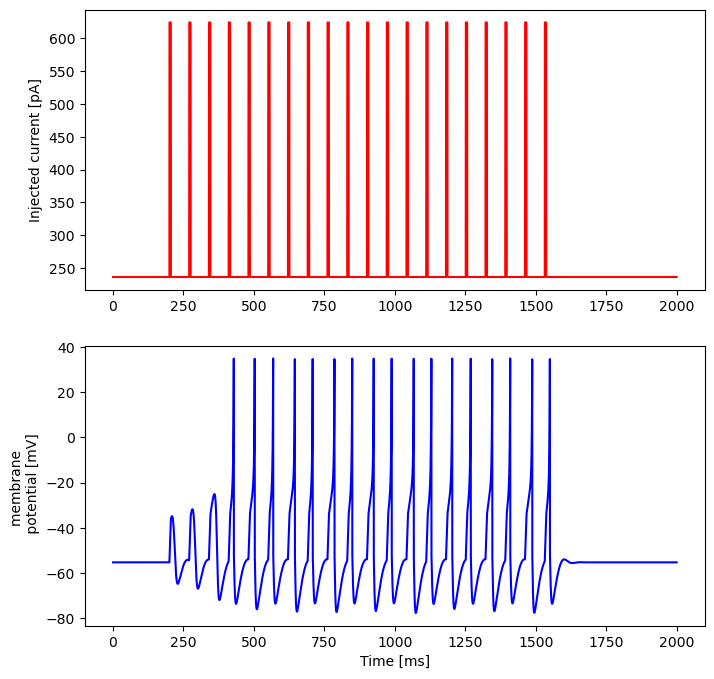

In [10]:
idx = 200
print(f"Number of pulses: {N_pulses}")
print(f"Pulse Frequency: {np.round(multipulse_freq[idx], 2)}")
print(f"Number of spikes: {num_spikes[idx]}")
print(f"Firing Frequency: {spike_freq[idx]}")

fig, ax = plot_potential_versus_injected(X[idx, :], T, I_multi[idx, :])# , split)

plt.show()

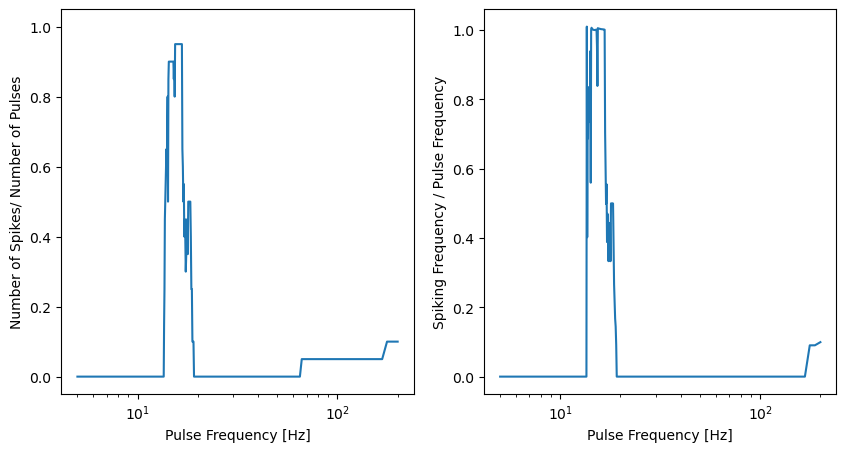

In [11]:
freq_ratio = spike_freq/multipulse_freq
spike_ratio = num_spikes/N_pulses

fig, ax = plt.subplots(1, 2, figsize = (10, 5))

ax[0].plot(multipulse_freq, spike_ratio)
ax[0].set(ylabel = "Number of Spikes/ Number of Pulses", xlabel = "Pulse Frequency [Hz]")
xmin = np.min(pulse_frequency)
xmax = np.max(pulse_frequency)
ax[0].hlines(y = 1, xmin = xmin, xmax = xmax, colors = "gray", linestyle = 'dashed')
ax[0].set_xscale('log')

ax[1].plot(multipulse_freq, freq_ratio)
ax[1].hlines(y = 1, xmin = xmin, xmax = xmax, colors = "gray", linestyle = 'dashed')
ax[1].set_xscale('log')
ax[1].set(ylabel = "Spiking Frequency / Pulse Frequency", xlabel = "Pulse Frequency [Hz]")

plt.show()